# Invoice Extraction with Faster RCNN
  
*NOTE: This requires Colab Pro in order to execute*
  
**AIM:** To take an invoice as input (if pdf then convert to .jpg), run it through Faster RCNN or YOLO model to form bounding boxes around relevant information.  
  
Steps:
1. Make appropriate installions for TensorFlow Object Detection API
2. Clone TensorFlow Object Detection API Git Repository
3. Convert PDF to image (Using simple python code)
4. Image annotation
5. Create Dataset
6. Make Label Map
7. Create TFRecord
8. Download Model
9. Configs and Hyperparameters
10. Model training
10. Inference
  
References used:  
https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=wN1BzORoIzV4&uniqifier=1  
https://colab.research.google.com/github/MarkDaoust/models/blob/tf_slim-2/research/object_detection/object_detection_tutorial.ipynb#scrollTo=mF-YlMl8c_bM

## 1. INSTALLATIONS
  
**REQUIREMENTS:**
- TensorFlow 2.x
- tf_slim
- pycocotools
- protobuf-compiler 
- python-lxml 
- python-pil
- Cython 
- pandas 
- lvis

In [1]:
#Mount onto google drive

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Invoice_Extraction" #Path to working directory

#Change current working directory to yours
import os
os.chdir(path)

%cd /content/drive/My Drive/Invoice_Extraction/TensorFlow

Mounted at /content/drive
/content/drive/My Drive/Invoice_Extraction/TensorFlow


In [2]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

     |████████████████████████████████| 352 kB 7.5 MB/s 


In [3]:
!pip install pycocotools

In [4]:
!apt-get install protobuf-compiler python-lxml python-pil
!pip install Cython pandas tf-slim lvis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,614 kB of archives.
After this operation, 8,908 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-pkg-resources all 39.0.1-2 [128 kB]
Get:3 http:/

---

## 2. CLONING/INSTALLING AND COMPILING
  
API's to be cloned: TensorFlow Object Detection API
  
TensorFlow Object Detection API Git Repository:  https://github.com/tensorflow/models   
  
**NOTE:** Before cloning the API, make sure you are within the correct directory.  
Withing directory of your chooseing, make a directory called 'TensorFlow', all cloning and downloads will be installed here.

In [5]:
%cd /content/drive/My Drive/Invoice_Extraction/TensorFlow

#Cloning
!git clone --quiet https://github.com/tensorflow/models.git

/content/drive/My Drive/Invoice_Extraction/TensorFlow


In [6]:
# Install the Object Detection API and compile protocols
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/drive/My Drive/Invoice_Extraction/TensorFlow/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1665514 sha256=e97a9ed871e64112d87426343c5c061f6a203986e5de2b661ba06429eaf4ec16
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf8rc6dz/wheels/2e/7a/c5/5a5154a4327b740f474f921ef5c6663acae3c9bd0b44e6ca58
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=8f0553f39093da19033fb96bd7f8311cbe5cc4162b8758fa962ef45fac8b6e81
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=f920f4cc72a7b724cbacf21c8d9d39fe46dd6cb77429e2a36b2b79995627d7ec
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=6bc9

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Imports required for the running of the codes

In [7]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [9]:
#run model builder test
!python /content/drive/MyDrive/Invoice_Extraction/TensorFlow/models/research/object_detection/builders/model_builder_tf2_test.py

2021-09-23 10:41:28.332668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 10:41:28.534543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 10:41:28.535200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-09-23 10:41:28.548427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-criti

---

## WORKSPACE
  
Your workspace should look as the following:  
  
![Workspace](https://drive.google.com/uc?export=view&id=1oDg4LyztTje_T3NvxfQP5KndME4CYb9n)  
  
**NOTE:** The cocoapi is optional and only if using COCO Dataset

---

### 3. CONVERT (.pdf to .jpg)
  
**Modules Required:**
- pdf2image 1.14.0: This module converts a PDF to a PIL object. (pip install pdf2image)
- poppler: This module allows to read, render, or modify PDF documents. (apt-get install poppler-utils)
  
Code saved in file: convert.py  
Path: ../Tensorflow/scripts/convert.py

In [ ]:
#Import required modules bofore running
from pdf2image import convert_from_path
import os

#Function returns name of .pdf files and path to the file.
#file = path to folder containing all .pdf files
def get_paths(folder):
    name = [] 
    paths = []
    count = 0
    for file in os.listdir(folder):
        if file.endswith(".pdf"):
            name.append(f[:-4])
            paths.append(folder+'/'+f)
            count = count+1
    return name, paths, count



#Function to convert pdf to image
#pdf_path = path to .pdf file
#name = name of the .pdf file
#save = path to directory where image is to be stored
def convert(paths, name, save, count):
    for i in range(count):
        pdf_path = paths[i]
        file_name = name[i]
        images = convert_from_path(pdf_path)
        for j in range(len(images)):
            images[i].save(save + '/' + file_name + '_' + str(j) +'.jpg', 'JPEG')

---

## 4. Image Annotation
  
Done using Makesense.AI  
  
Labels used:
1. Keyword
2. Bill_from
3. Bill_to
4. Date
5. Invoice_number
6. Purchase_number
7. Total
8. Details
9. Balance
10. Tax
  
Required formats:
- For Faster RCNN: .xml files
  
The xml files should look like:  
  
![xml](https://drive.google.com/uc?export=view&id=1qFtmZMsgKfOOvx4xlI0qa-gXS9y2flGx)

---

## 5. Create Dataset
  
*Done on Roboflow*  
  
Train = 0.7  
Validation = 0.2  
Test = 0.1  
  
Addition preprocessing:  
- Resize: Stretch to 416x416
- Data Augmentation:
 - 90° Rotate: Clockwise, Counter-Clockwise
 - Crop: 0% Minimum Zoom, 20% Maximum Zoom
  
Final Dataset = 96 images + corresponding annotations (.xml)  
  
**HEATMAP OF ENTIRE DATASET:**  
  
![HeatMap](https://drive.google.com/uc?export=view&id=1APl1UsRstB8k-BiE59IxvxHhv6HcOYII)

---

## 6. Label Map  
  
Save it as a .pbtxt file within ../Tensorflow/workspace/training_demo/annotations  
  
**USAGE:** TensorFlow requires a label map, which namely maps each of the used labels to an integer values. This label map is used both by the training and detection processes.

---

## 7. Create TFRecord
  
A TFRecord file stores your data as a sequence of binary strings. This is done by a code in generate_tfrecord.py withing the scripts directory.  
  
**Paths:**  
  
PATH_TO_IMAGES_FOLDER (train) : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/images/train  
  
PATH_TO_IMAGES_FOLDER (test) : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/images/test  
  
PATH_TO_LABEL_MAP : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/annotations/label_map.pbtxt   
  
PATH_TO_STORE (train.record) : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/annotations/train.record  
  
PATH_TO_STORE (test.record) : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/annotations/test.record  

In [ ]:
#In general
#Run within ../TensorFlow/scripts
!python generate_tfrecord.py -x [PATH_TO_IMAGES_FOLDER] -l [PATH_TO_LABEL_MAP] -o [PATH_TO_STORE]

#Run seperately for both train and test

---

## 8. DOWNLOAD MODEL
  
Models are available in: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md  
  
**NOTE:** The download does not happen if accessing through Google Chrome. Internet Explorer can download it.  
  
Model required: Faster RCNN  
  
**MODELS SELECTED:** 
- Faster R-CNN ResNet50 V1 640x640
  
The models are downloaded as a .tar.gz file. It is to be saved within path:  
/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/pre-trained-models

In [ ]:
%cd /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/pre-trained-models

#Extraction
!tar -xzvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

Inside the folders of both there models, there will be a pipeline.config file to which changes need to be made. Within the training_demo/model directory make seperate folders for each of the models and dupilcate the corresponding pipeline.config files there.

**Changes to be made to pipeline.config file:**  
1. num_classes : Change to 10 (line 11)
2. batch_size : 1 (since very small dataset) (line 93)
3. fine_tune_checkpoint : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/pre-trained-models/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/checkpoint/ckpt-0 (line 113)
4. fine_tune_checkpoint_type : "detection" (line 114)
5. use_bfloat16 : false (line 142)
6. label_map_path: '../TensorFlow/workspace/training_demo/annotations/label_map.pbtxt'
7. input_path : '../TensorFlow/workspace/training_demo/annotations/train.record'
8. metrics_set: "coco_detection_metrics"
9. use_moving_averages: false

---

## 9. NAMING PARAMETERS

In [33]:
#Depending on model chosen
model_pipeline = '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/pipeline.config'

import os
pipeline_fname = os.path.join(model_pipeline)

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 100000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

model_dir = '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50'

---

## 10. Train the model  
  
Copy the python files model_main_tf2.py and exporter_main_v2.py from TensorFlow/models/research/object_detection to the training_demo folder and run the following code from within that folder

In [34]:
%cd /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo

/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo


In [35]:
!python model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
 'learning_rate': 0.0}
I0923 14:50:22.909412 140504732772224 model_lib_v2.py:701] {'Loss/BoxClassifierLoss/classification_loss': 0.0008040086,
 'Loss/BoxClassifierLoss/localization_loss': 0.0047900267,
 'Loss/RPNLoss/localization_loss': 1.6129912e-05,
 'Loss/RPNLoss/objectness_loss': 0.00022649742,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.0058366624,
 'learning_rate': 0.0}
INFO:tensorflow:Step 68900 per-step time 0.154s
I0923 14:50:38.281878 140504732772224 model_lib_v2.py:700] Step 68900 per-step time 0.154s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.00028976897,
 'Loss/BoxClassifierLoss/localization_loss': 0.0043427367,
 'Loss/RPNLoss/localization_loss': 1.4130076e-05,
 'Loss/RPNLoss/objectness_loss': 0.00015643341,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.004803069,
 'learning_rate': 0.0}
I0923 14:50:38.282209 140504732772224 model_lib_v2.py:701] {'Loss/BoxClassifierLoss/classifica

### Result:  
  
- Total loss = 0.0042085997
- Learning rate = < 10^-5

In [52]:
#Location where checkpoints are saved
%ls '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50'

checkpoint                    ckpt-97.data-00000-of-00001
ckpt-100.data-00000-of-00001  ckpt-97.index
ckpt-100.index                ckpt-98.data-00000-of-00001
ckpt-101.data-00000-of-00001  ckpt-98.index
ckpt-101.index                ckpt-99.data-00000-of-00001
ckpt-95.data-00000-of-00001   ckpt-99.index
ckpt-95.index                 pipeline.config
ckpt-96.data-00000-of-00001   train/
ckpt-96.index


---

## 11. Export the weights  

Run the following code within training_demo folder  

In [42]:
#run conversion script
import re
import numpy as np

output_directory = '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/Out2'

#place the model weights you would like to export here
last_model_path = '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50'
print(last_model_path)
!python /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_fname}

/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50
2021-09-23 16:14:52.743418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 16:14:52.790210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 16:14:52.790872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 16:14:52.817637: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operatio

In [53]:
#Location of saved weights
%ls '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/Out2/saved_model'

assets/  saved_model.pb  variables/


---

## 12. Inference on test images  

### Required imports:

In [43]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

### Function to convert test image to numpy array:

In [44]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Restoring saved model

In [46]:
import pathlib

result = '/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50'
filenames = list(pathlib.Path(result).glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_fname

#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-100.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-101.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-95.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-96.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-97.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-98.index'), PosixPath('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/FasterRCNN_ResNet50/ckpt-99.index')]


### Getting the Label Map

In [47]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### TESTING

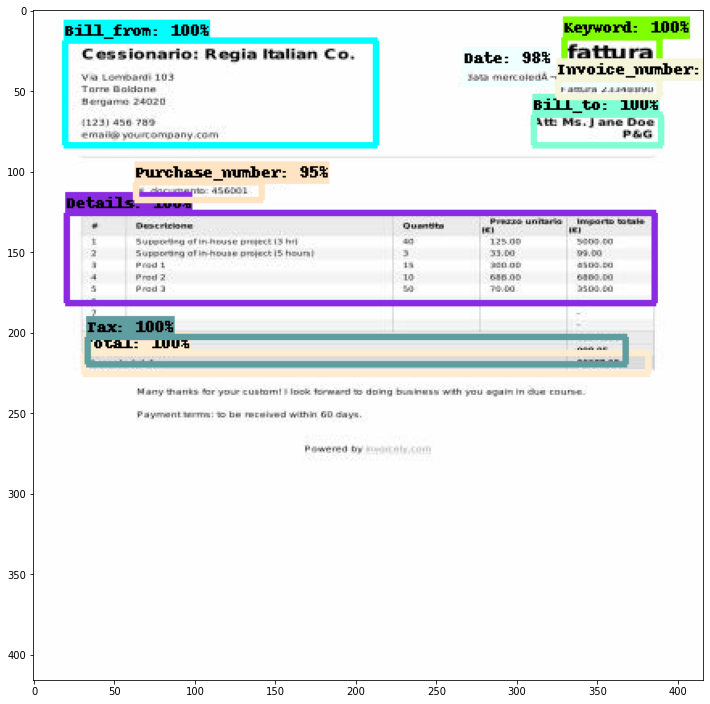

In [51]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/images/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## RESULT:
  
All the required information was detected.  
  
Time taken for training: 4 hours  
Space taken: ~5GB

### LOCATION:
  
Saved Model : /content/drive/MyDrive/Invoice_Extraction/TensorFlow/workspace/training_demo/models/Out2  
